In [1]:
# Imports
import polars as pl
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Plotting setup
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

print("✅ Imports complete")

✅ Imports complete


## Setup: File Paths and Helper Functions

In [2]:
# File paths
DATA_DIR = Path("data/raw")
BUSINESS_FILE = DATA_DIR / "yelp_academic_dataset_business.json"
USER_FILE = DATA_DIR / "yelp_academic_dataset_user.json"
REVIEW_FILE = DATA_DIR / "yelp_academic_dataset_review.json"


# Helper function to load NDJSON files
def load_ndjson(filepath, sample_size=None):
    """Load newline-delimited JSON file using Polars or fallback to manual parsing"""
    print(f"Loading {filepath.name}...")

    if not filepath.exists():
        print(f" File not found: {filepath}")
        return None

    try:
        # Try Polars native reader first
        if sample_size:
            # For sampling, read line by line
            data = []
            with open(filepath, "r") as f:
                for i, line in enumerate(f):
                    if i >= sample_size:
                        break
                    data.append(json.loads(line))
            df = pl.DataFrame(data)
        else:
            df = pl.read_ndjson(filepath)

        print(f"✅ Loaded {len(df):,} records")
        return df

    except Exception as e:
        print(f"  Native reader failed, using manual parsing...")
        # Fallback: line-by-line parsing
        data = []
        with open(filepath, "r") as f:
            for i, line in enumerate(f):
                if sample_size and i >= sample_size:
                    break
                data.append(json.loads(line))
                if (i + 1) % 100000 == 0:
                    print(f"  Progress: {i+1:,} records...")

        df = pl.DataFrame(data)
        print(f"✅ Loaded {len(df):,} records")
        return df


print("✅ Helper functions ready")

✅ Helper functions ready


## Part 1: Load and Explore Businesses

First, let's understand the geographic distribution of businesses.

In [3]:
# Load all businesses
df_businesses = load_ndjson(BUSINESS_FILE)

if df_businesses is not None:
    print(f"\n Dataset Info:")
    print(f"  Rows: {len(df_businesses):,}")
    print(f"  Columns: {len(df_businesses.columns)}")
    print(f"\n Sample:")
    display(df_businesses.head(3))

Loading yelp_academic_dataset_business.json...
✅ Loaded 150,346 records

 Dataset Info:
  Rows: 150,346
  Columns: 14

 Sample:


business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
str,str,str,str,str,str,f64,f64,f64,i64,i64,struct[33],str,struct[7]
"""Pns2l4eNsfO8kk83dixA6A""","""Abby Rappoport, LAC, CMQ""","""1616 Chapala St, Ste 2""","""Santa Barbara""","""CA""","""93101""",34.426679,-119.711197,5.0,7,0,"{null,null,null,null,null,null,null,null,null,null,null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Doctors, Traditional Chinese M…",null
"""mpf3x-BjTdTEA3yCZrAYPw""","""The UPS Store""","""87 Grasso Plaza Shopping Cente…","""Affton""","""MO""","""63123""",38.551126,-90.335695,3.0,15,1,"{null,""True"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}","""Shipping Centers, Local Servic…","{""0:0-0:0"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-18:30"",""8:0-14:0"",null}"
"""tUFrWirKiKi_TAnsVWINQQ""","""Target""","""5255 E Broadway Blvd""","""Tucson""","""AZ""","""85711""",32.223236,-110.880452,3.5,22,0,"{""{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"",""True"",null,""False"",""False"",""False"",""False"",null,null,null,""2"",""False"",""False"",""False"",null,null,""False"",""u'no'"",""True"",""False"",""False"",null,""True"",null,null,null,null,null,null,null,null,null,null}","""Department Stores, Shopping, F…","{""8:0-22:0"",""8:0-22:0"",""8:0-22:0"",""8:0-22:0"",""8:0-23:0"",""8:0-23:0"",""8:0-22:0""}"


In [4]:
# Analyze geographic distribution
city_stats = (
    df_businesses.group_by(["city", "state"])
    .agg(
        [
            pl.count().alias("business_count"),
            pl.col("review_count").sum().alias("total_reviews"),
            pl.col("stars").mean().alias("avg_stars"),
            pl.col("is_open").mean().alias("pct_open"),
        ]
    )
    .sort("business_count", descending=True)
)

print("=== TOP 20 CITIES BY BUSINESS COUNT ===\n")
display(city_stats.head(20))

=== TOP 20 CITIES BY BUSINESS COUNT ===



/var/folders/d9/jrdhm0fs42jgp293l0fm5cnm0000gn/T/ipykernel_44075/3535663139.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("business_count"),


city,state,business_count,total_reviews,avg_stars,pct_open
str,str,u32,i64,f64,f64
"""Philadelphia""","""PA""",14567,936207,3.623224,0.723553
"""Tucson""","""AZ""",9249,387239,3.594767,0.814466
"""Tampa""","""FL""",9048,439450,3.583057,0.797635
"""Indianapolis""","""IN""",7540,349228,3.579708,0.781698
"""Nashville""","""TN""",6968,440988,3.637629,0.774254
…,…,…,…,…,…
"""Wilmington""","""DE""",1445,42989,3.424567,0.824221
"""Franklin""","""TN""",1410,54688,3.606383,0.802128
"""St. Louis""","""MO""",1254,61256,3.664274,0.839713


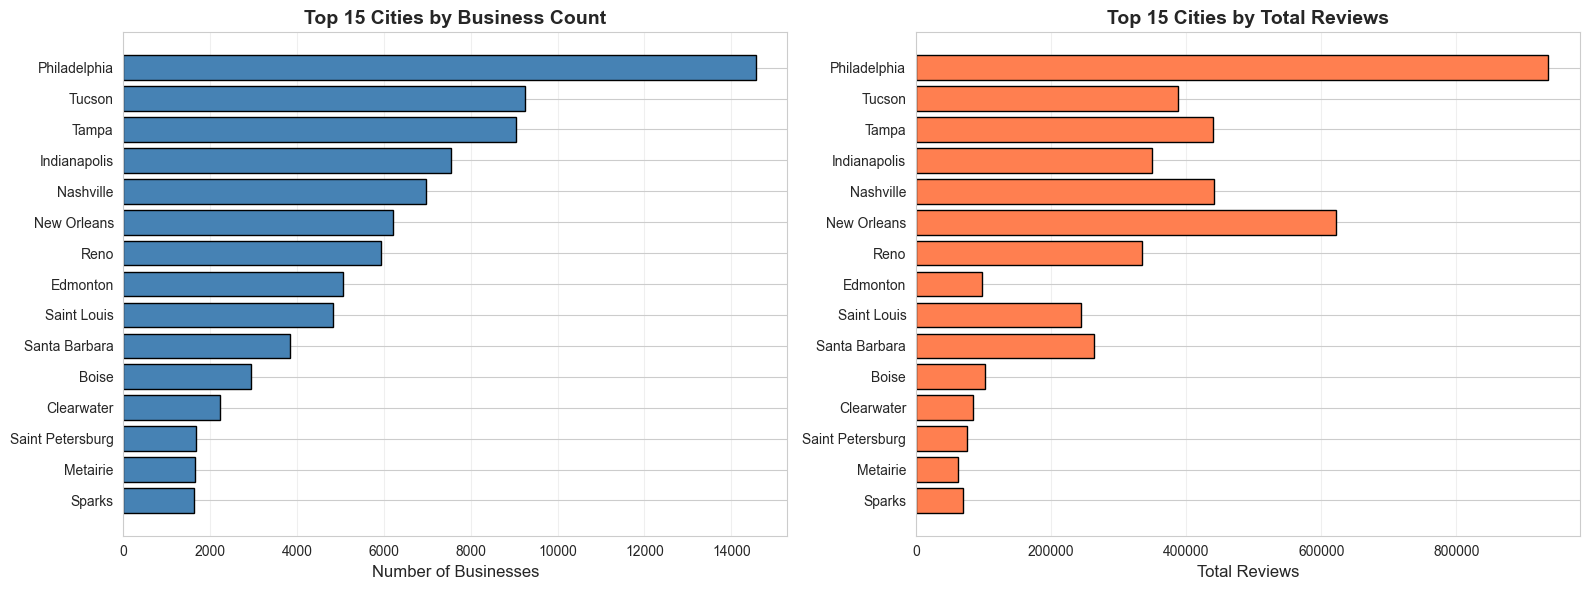

In [5]:
# Visualize top cities
top_15_cities = city_stats.head(15)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Business count
cities = top_15_cities["city"].to_list()
counts = top_15_cities["business_count"].to_list()
ax1.barh(cities[::-1], counts[::-1], color="steelblue", edgecolor="black")
ax1.set_xlabel("Number of Businesses", fontsize=12)
ax1.set_title("Top 15 Cities by Business Count", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3, axis="x")

# Total reviews
reviews = top_15_cities["total_reviews"].to_list()
ax2.barh(cities[::-1], reviews[::-1], color="coral", edgecolor="black")
ax2.set_xlabel("Total Reviews", fontsize=12)
ax2.set_title("Top 15 Cities by Total Reviews", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.show()

### Focus: Santa Barbara Analysis

In [6]:
# Filter to Santa Barbara, CA
sb_businesses = df_businesses.filter(
    (pl.col("city") == "Santa Barbara") & (pl.col("state") == "CA")
)

print("=== SANTA BARBARA BUSINESSES ===\n")
print(f" Total businesses: {len(sb_businesses):,}")
print(f" Average rating: {sb_businesses['stars'].mean():.2f}")
print(f" Total reviews: {sb_businesses['review_count'].sum():,}")
print(
    f" Currently open: {sb_businesses['is_open'].sum():,} ({sb_businesses['is_open'].mean()*100:.1f}%)"
)

print(f"\n Rating Distribution:")
display(sb_businesses["stars"].value_counts().sort("stars"))

=== SANTA BARBARA BUSINESSES ===

 Total businesses: 3,829
 Average rating: 4.05
 Total reviews: 262,853
 Currently open: 3,020 (78.9%)

 Rating Distribution:


stars,count
f64,u32
1.0,15
1.5,43
2.0,123
2.5,199
3.0,305
3.5,475
4.0,771
4.5,923
5.0,975


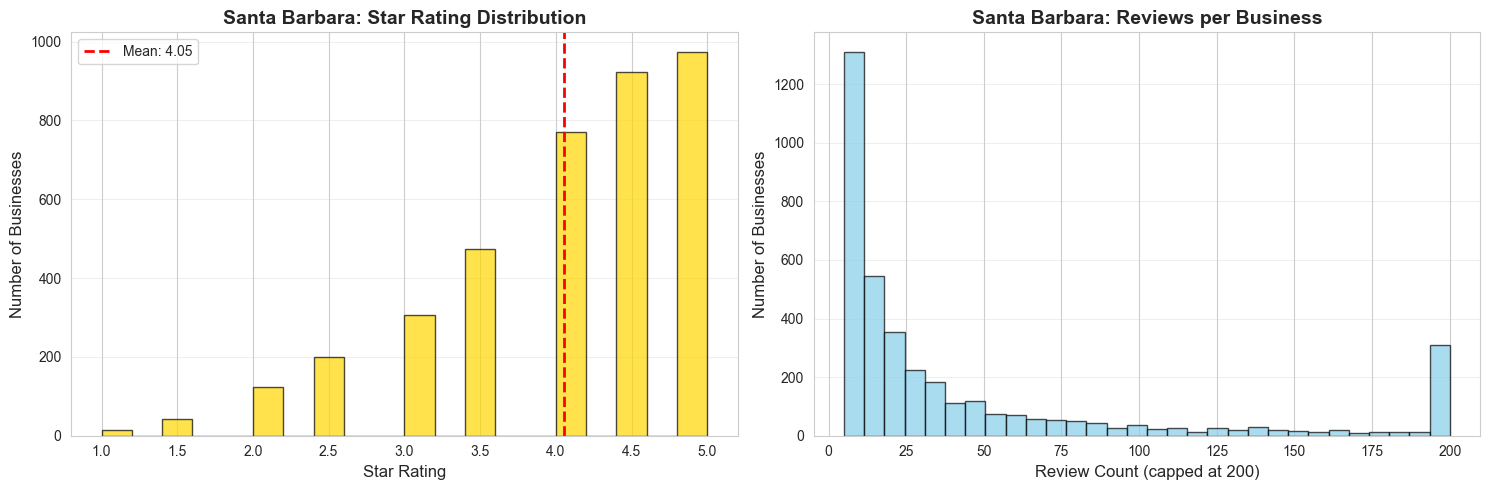

In [7]:
# Visualize Santa Barbara businesses
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Star distribution
sb_stars = sb_businesses["stars"].to_list()
ax1.hist(sb_stars, bins=20, color="gold", edgecolor="black", alpha=0.7)
ax1.axvline(
    sb_businesses["stars"].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f'Mean: {sb_businesses["stars"].mean():.2f}',
)
ax1.set_xlabel("Star Rating", fontsize=12)
ax1.set_ylabel("Number of Businesses", fontsize=12)
ax1.set_title("Santa Barbara: Star Rating Distribution", fontsize=14, fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3, axis="y")

# Review count distribution
sb_reviews_capped = [min(x, 200) for x in sb_businesses["review_count"].to_list()]
ax2.hist(sb_reviews_capped, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
ax2.set_xlabel("Review Count (capped at 200)", fontsize=12)
ax2.set_ylabel("Number of Businesses", fontsize=12)
ax2.set_title("Santa Barbara: Reviews per Business", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

## Part 2: Analyze Users (Reviewers)

Let's understand reviewer behavior and identify quality reviewers.

In [8]:
# Load users
df_users = load_ndjson(USER_FILE)

if df_users is not None:
    print(f"\n User Statistics:")
    print(f"  Total users: {len(df_users):,}")
    print(f"\n Review count stats:")
    print(df_users["review_count"].describe())

Loading yelp_academic_dataset_user.json...


✅ Loaded 1,987,897 records

 User Statistics:
  Total users: 1,987,897

 Review count stats:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 1.987897e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 23.394409  │
│ std        ┆ 82.566992  │
│ min        ┆ 0.0        │
│ 25%        ┆ 2.0        │
│ 50%        ┆ 5.0        │
│ 75%        ┆ 17.0       │
│ max        ┆ 17473.0    │
└────────────┴────────────┘


### Threshold Analysis: Finding Quality Reviewers

In [9]:
# Test different review count thresholds
# minimum number of reviews a user must have written to be considered a "quality reviewer"
thresholds = [10, 20, 50, 100, 150, 200, 250, 300, 500, 1000]

threshold_results = []
for thresh in thresholds:
    count = df_users.filter(pl.col("review_count") >= thresh).height
    pct = (count / len(df_users)) * 100
    threshold_results.append(
        {"threshold": thresh, "user_count": count, "percentage": round(pct, 2)}
    )

df_thresholds = pl.DataFrame(threshold_results)

print("=== THRESHOLD ANALYSIS ===\n")
print("How many users meet each review count threshold?\n")
display(df_thresholds)

=== THRESHOLD ANALYSIS ===

How many users meet each review count threshold?



threshold,user_count,percentage
i64,i64,f64
10,726519,36.55
20,436498,21.96
50,189552,9.54
100,91774,4.62
150,56660,2.85
200,38628,1.94
250,27999,1.41
300,21150,1.06
500,8618,0.43


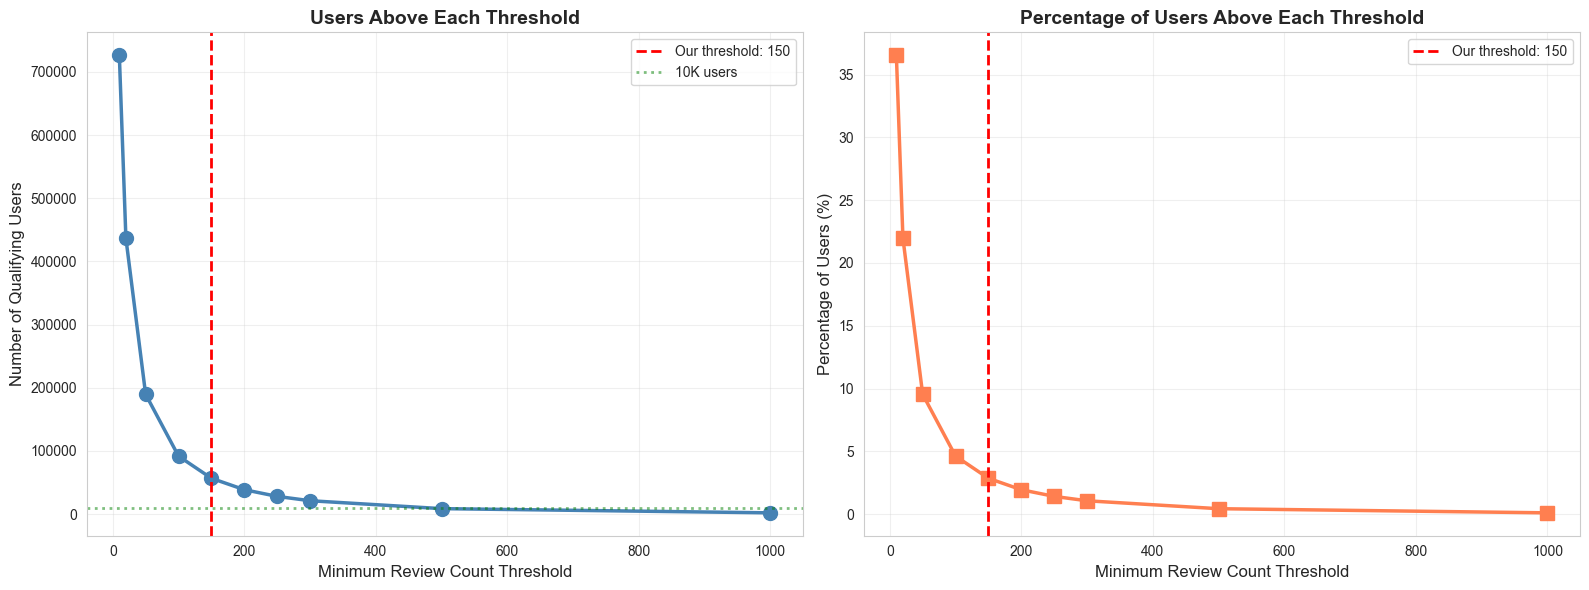


 With threshold of 150 reviews:
   ✓ 56,660 users qualify (2.85%)


In [10]:
# Visualize threshold trade-offs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

threshs = df_thresholds["threshold"].to_list()
user_counts = df_thresholds["user_count"].to_list()
percentages = df_thresholds["percentage"].to_list()

# Absolute count
ax1.plot(
    threshs, user_counts, marker="o", linewidth=2.5, markersize=10, color="steelblue"
)
ax1.axvline(x=150, color="red", linestyle="--", linewidth=2, label="Our threshold: 150")
ax1.axhline(
    y=10000, color="green", linestyle=":", linewidth=2, alpha=0.5, label="10K users"
)
ax1.set_xlabel("Minimum Review Count Threshold", fontsize=12)
ax1.set_ylabel("Number of Qualifying Users", fontsize=12)
ax1.set_title("Users Above Each Threshold", fontsize=14, fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Percentage
ax2.plot(threshs, percentages, marker="s", linewidth=2.5, markersize=10, color="coral")
ax2.axvline(x=150, color="red", linestyle="--", linewidth=2, label="Our threshold: 150")
ax2.set_xlabel("Minimum Review Count Threshold", fontsize=12)
ax2.set_ylabel("Percentage of Users (%)", fontsize=12)
ax2.set_title(
    "Percentage of Users Above Each Threshold", fontsize=14, fontweight="bold"
)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show our chosen threshold
chosen_row = df_thresholds.filter(pl.col("threshold") == 150)
if len(chosen_row) > 0:
    count = chosen_row["user_count"][0]
    pct = chosen_row["percentage"][0]
    print(f"\n With threshold of 150 reviews:")
    print(f"   ✓ {count:,} users qualify ({pct}%)")

In [11]:
# Filter to quality reviewers
quality_reviewers = df_users.filter(pl.col("review_count") >= 150)

print("=== QUALITY REVIEWERS (150+ reviews) ===\n")
print(f" Statistics:")
print(f"  Total users: {len(df_users):,}")
print(f"  Quality reviewers: {len(quality_reviewers):,}")
print(f"  Percentage: {(len(quality_reviewers)/len(df_users)*100):.2f}%")

print(f"\n Their review counts:")
print(quality_reviewers["review_count"].describe())

print(f"\n Their average ratings:")
print(quality_reviewers["average_stars"].describe())

=== QUALITY REVIEWERS (150+ reviews) ===

 Statistics:
  Total users: 1,987,897
  Quality reviewers: 56,660
  Percentage: 2.85%

 Their review counts:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 56660.0    │
│ null_count ┆ 0.0        │
│ mean       ┆ 346.550777 │
│ std        ┆ 338.607065 │
│ min        ┆ 150.0      │
│ 25%        ┆ 186.0      │
│ 50%        ┆ 248.0      │
│ 75%        ┆ 381.0      │
│ max        ┆ 17473.0    │
└────────────┴────────────┘

 Their average ratings:
shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 56660.0  │
│ null_count ┆ 0.0      │
│ mean       ┆ 3.85386  │
│ std        ┆ 0.388386 │
│ min        ┆ 1.21     │
│ 25%        ┆ 3.63     │
│ 50%        ┆ 3.87     │
│ 75%        ┆ 4.11     │
│ max        ┆ 5.0      │
└───────────

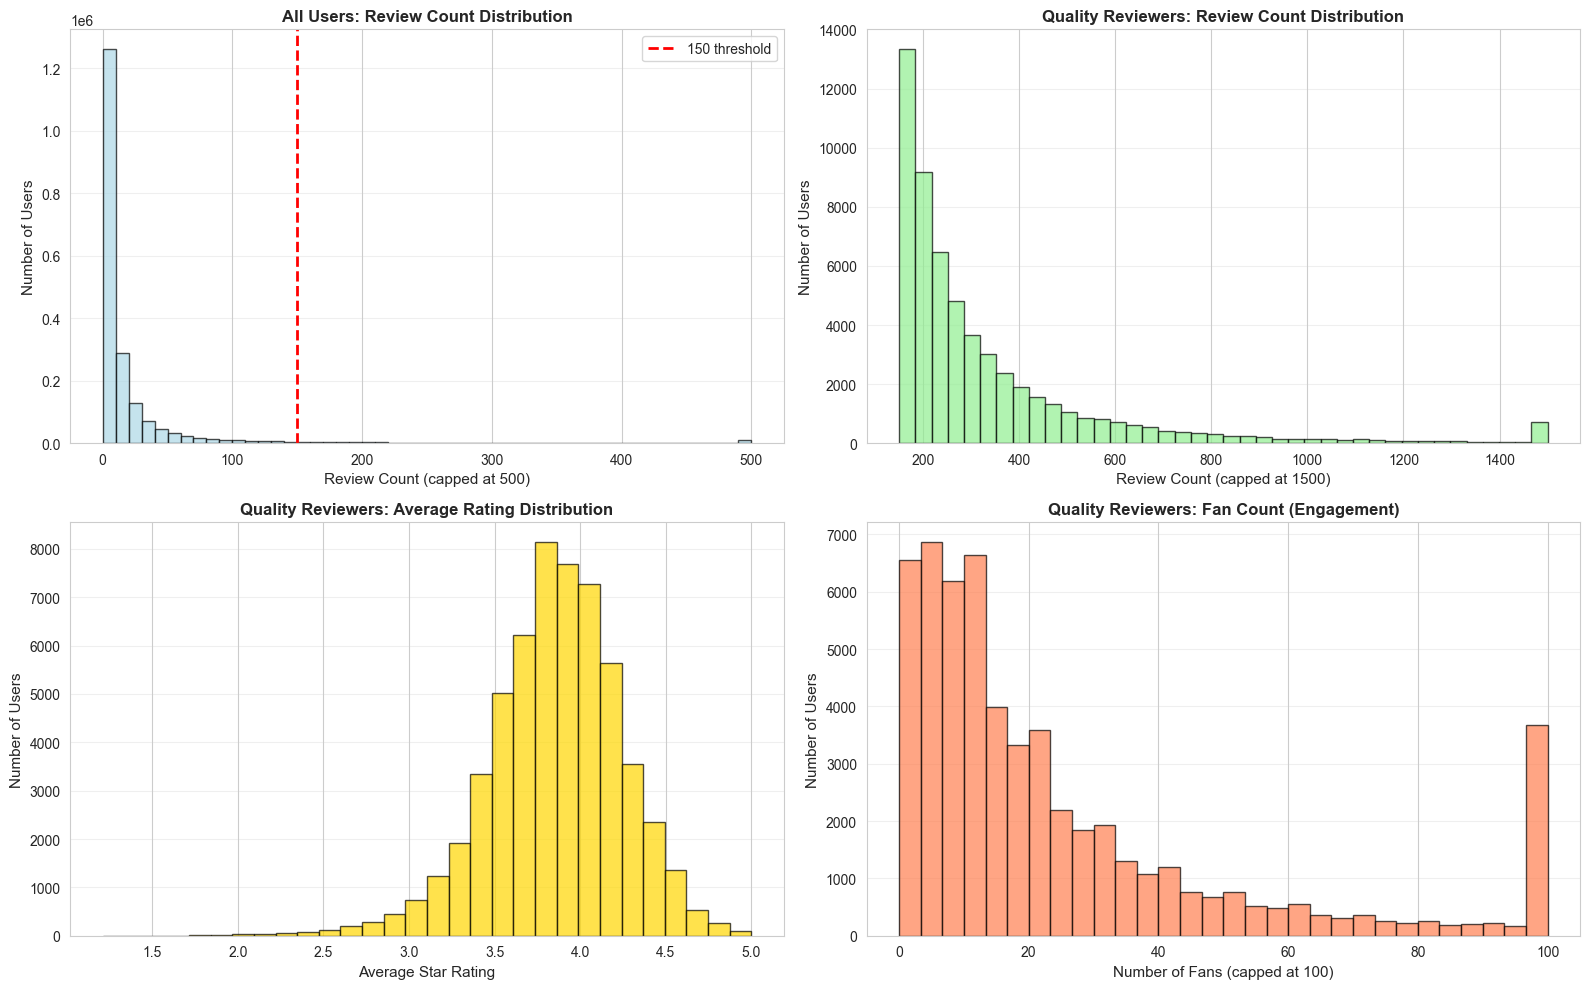

In [12]:
# Visualize reviewer distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# All users review count (capped)
all_reviews_capped = [min(x, 500) for x in df_users["review_count"].to_list()]
axes[0, 0].hist(
    all_reviews_capped, bins=50, color="lightblue", edgecolor="black", alpha=0.7
)
axes[0, 0].axvline(150, color="red", linestyle="--", linewidth=2, label="150 threshold")
axes[0, 0].set_xlabel("Review Count (capped at 500)", fontsize=11)
axes[0, 0].set_ylabel("Number of Users", fontsize=11)
axes[0, 0].set_title(
    "All Users: Review Count Distribution", fontsize=12, fontweight="bold"
)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis="y")

# Quality reviewers only
quality_reviews_capped = [
    min(x, 1500) for x in quality_reviewers["review_count"].to_list()
]
axes[0, 1].hist(
    quality_reviews_capped, bins=40, color="lightgreen", edgecolor="black", alpha=0.7
)
axes[0, 1].set_xlabel("Review Count (capped at 1500)", fontsize=11)
axes[0, 1].set_ylabel("Number of Users", fontsize=11)
axes[0, 1].set_title(
    "Quality Reviewers: Review Count Distribution", fontsize=12, fontweight="bold"
)
axes[0, 1].grid(True, alpha=0.3, axis="y")

# Average stars distribution
axes[1, 0].hist(
    quality_reviewers["average_stars"].to_list(),
    bins=30,
    color="gold",
    edgecolor="black",
    alpha=0.7,
)
axes[1, 0].set_xlabel("Average Star Rating", fontsize=11)
axes[1, 0].set_ylabel("Number of Users", fontsize=11)
axes[1, 0].set_title(
    "Quality Reviewers: Average Rating Distribution", fontsize=12, fontweight="bold"
)
axes[1, 0].grid(True, alpha=0.3, axis="y")

fans_capped = [min(x, 100) for x in quality_reviewers["fans"].to_list()]
axes[1, 1].hist(fans_capped, bins=30, color="coral", edgecolor="black", alpha=0.7)
axes[1, 1].set_xlabel("Number of Fans (capped at 100)", fontsize=11)
axes[1, 1].set_ylabel("Number of Users", fontsize=11)
axes[1, 1].set_title(
    "Quality Reviewers: Fan Count (Engagement)", fontsize=12, fontweight="bold"
)
axes[1, 1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

In [13]:
# Show top reviewers
top_reviewers = quality_reviewers.sort("review_count", descending=True).head(20)

print("=== TOP 20 REVIEWERS ===\n")
display(
    top_reviewers.select(
        ["name", "review_count", "average_stars", "fans", "yelping_since"]
    )
)

=== TOP 20 REVIEWERS ===



name,review_count,average_stars,fans,yelping_since
str,i64,f64,i64,str
"""Fox""",17473,3.77,3493,"""2009-05-26 11:33:58"""
"""Victor""",16978,3.35,1462,"""2007-12-08 14:56:45"""
"""Bruce""",16567,3.67,867,"""2009-03-08 21:47:44"""
"""Shila""",12868,3.87,300,"""2010-10-17 06:35:06"""
"""Kim""",9941,3.81,825,"""2006-05-31 21:27:42"""
…,…,…,…,…
"""Misha""",5163,3.99,197,"""2007-10-29 08:53:07"""
"""Michael""",5061,3.94,1238,"""2008-01-31 02:55:30"""
"""Stefany""",5014,3.43,896,"""2011-06-29 14:40:01"""


## Part 3: Analyze Reviews

Understanding review patterns and content.

In [14]:
# Load reviews
df_reviews = load_ndjson(REVIEW_FILE)

if df_reviews is not None:
    # Add text length column
    df_reviews = df_reviews.with_columns(
        pl.col("text").str.len_chars().alias("text_length")
    )

    print(f"\n Review Statistics:")
    print(f"  Total reviews: {len(df_reviews):,}")
    print(f"  Date range: {df_reviews['date'].min()} to {df_reviews['date'].max()}")
    print(f"  Average rating: {df_reviews['stars'].mean():.2f}")
    print(f"  Average length: {df_reviews['text_length'].mean():.0f} characters")

Loading yelp_academic_dataset_review.json...
✅ Loaded 6,990,280 records

 Review Statistics:
  Total reviews: 6,990,280
  Date range: 2005-02-16 03:23:22 to 2022-01-19 19:48:45
  Average rating: 3.75
  Average length: 568 characters


In [15]:
# Review patterns
print("=== REVIEW PATTERNS ===\n")

print(" Star Distribution:")
star_dist = df_reviews["stars"].value_counts().sort("stars")
display(star_dist)

print("\n Text Length Statistics:")
print(df_reviews["text_length"].describe())

=== REVIEW PATTERNS ===

 Star Distribution:


stars,count
f64,u32
1.0,1069561
2.0,544240
3.0,691934
4.0,1452918
5.0,3231627



 Text Length Statistics:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 6.99028e6  │
│ null_count ┆ 0.0        │
│ mean       ┆ 567.764436 │
│ std        ┆ 527.257809 │
│ min        ┆ 1.0        │
│ 25%        ┆ 229.0      │
│ 50%        ┆ 406.0      │
│ 75%        ┆ 720.0      │
│ max        ┆ 5000.0     │
└────────────┴────────────┘


/var/folders/d9/jrdhm0fs42jgp293l0fm5cnm0000gn/T/ipykernel_44075/1932525274.py:56: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))


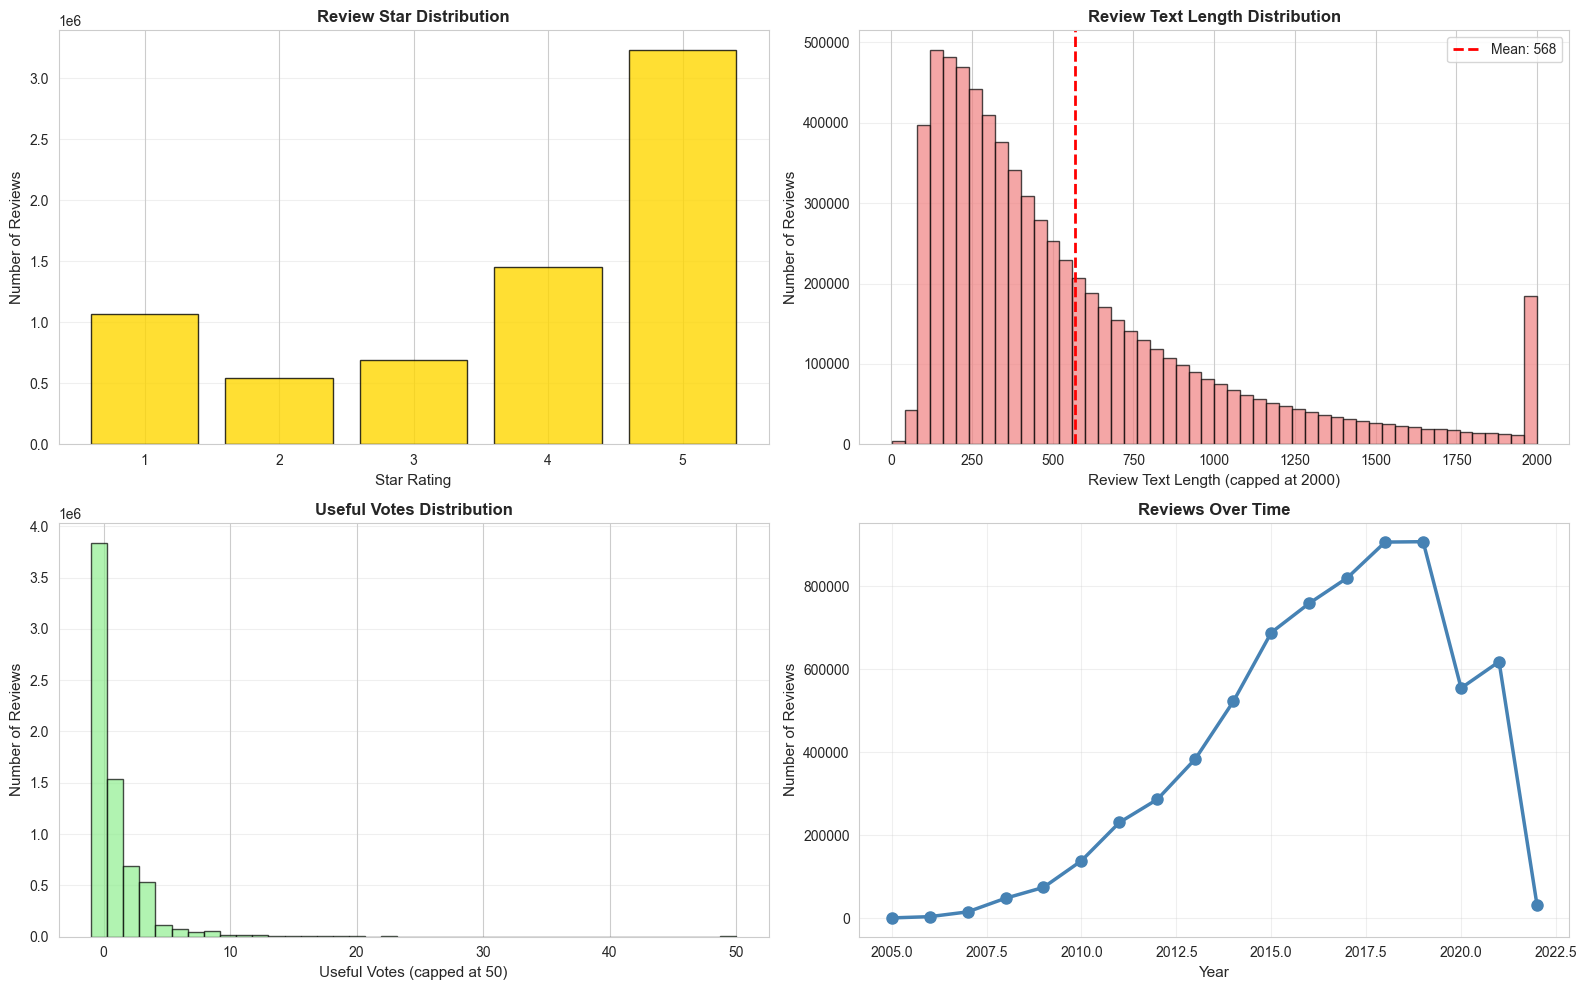

In [16]:
# Visualize review patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Star distribution
star_counts = df_reviews["stars"].value_counts().sort("stars")
axes[0, 0].bar(
    star_counts["stars"].to_list(),
    star_counts["count"].to_list(),
    color="gold",
    edgecolor="black",
    alpha=0.8,
)
axes[0, 0].set_xlabel("Star Rating", fontsize=11)
axes[0, 0].set_ylabel("Number of Reviews", fontsize=11)
axes[0, 0].set_title("Review Star Distribution", fontsize=12, fontweight="bold")
axes[0, 0].grid(True, alpha=0.3, axis="y")

# Text length
text_lengths_capped = [min(x, 2000) for x in df_reviews["text_length"].to_list()]
axes[0, 1].hist(
    text_lengths_capped, bins=50, color="lightcoral", edgecolor="black", alpha=0.7
)
axes[0, 1].axvline(
    df_reviews["text_length"].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f'Mean: {df_reviews["text_length"].mean():.0f}',
)
axes[0, 1].set_xlabel("Review Text Length (capped at 2000)", fontsize=11)
axes[0, 1].set_ylabel("Number of Reviews", fontsize=11)
axes[0, 1].set_title("Review Text Length Distribution", fontsize=12, fontweight="bold")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis="y")

# Useful votes
useful_capped = [min(x, 50) for x in df_reviews["useful"].to_list()]
axes[1, 0].hist(
    useful_capped, bins=40, color="lightgreen", edgecolor="black", alpha=0.7
)
axes[1, 0].set_xlabel("Useful Votes (capped at 50)", fontsize=11)
axes[1, 0].set_ylabel("Number of Reviews", fontsize=11)
axes[1, 0].set_title("Useful Votes Distribution", fontsize=12, fontweight="bold")
axes[1, 0].grid(True, alpha=0.3, axis="y")

# Reviews over time
try:
    df_by_year = (
        df_reviews.with_columns(
            pl.col("date")
            .str.strptime(pl.Date, format="%Y-%m-%d %H:%M:%S")
            .dt.year()
            .alias("year")
        )
        .group_by("year")
        .agg(pl.count().alias("count"))
        .sort("year")
    )

    axes[1, 1].plot(
        df_by_year["year"].to_list(),
        df_by_year["count"].to_list(),
        marker="o",
        linewidth=2.5,
        markersize=8,
        color="steelblue",
    )
    axes[1, 1].set_xlabel("Year", fontsize=11)
    axes[1, 1].set_ylabel("Number of Reviews", fontsize=11)
    axes[1, 1].set_title("Reviews Over Time", fontsize=12, fontweight="bold")
    axes[1, 1].grid(True, alpha=0.3)
except:
    axes[1, 1].text(0.5, 0.5, "Unable to parse dates", ha="center", va="center")

plt.tight_layout()
plt.show()

## Part 4: Data Filtering Process

**Step-by-step reduction from millions to thousands**

In [17]:
print("=" * 70)
print("DATA FILTERING PIPELINE")
print("=" * 70)

print("\n STARTING DATASET:")
print(f"  Businesses: {len(df_businesses):>12,}")
print(f"  Users:      {len(df_users):>12,}")
print(f"  Reviews:    {len(df_reviews):>12,}")

DATA FILTERING PIPELINE

 STARTING DATASET:
  Businesses:      150,346
  Users:         1,987,897
  Reviews:       6,990,280


In [18]:
# STEP 1: Geographic Filter - Santa Barbara
print("\n" + "=" * 70)
print("STEP 1: FILTER TO SANTA BARBARA, CA")
print("=" * 70)

sb_business_ids = set(sb_businesses["business_id"].to_list())

print(f"\n Result:")
print(f"  Businesses: {len(df_businesses):>12,} → {len(sb_businesses):>12,}")


STEP 1: FILTER TO SANTA BARBARA, CA

 Result:
  Businesses:      150,346 →        3,829


In [19]:
# STEP 2: Filter reviews to Santa Barbara
print("\n" + "=" * 70)
print("STEP 2: FILTER REVIEWS TO SANTA BARBARA BUSINESSES")
print("=" * 70)

sb_reviews = df_reviews.filter(pl.col("business_id").is_in(list(sb_business_ids)))

print(f"\n Result:")
print(f"  Reviews: {len(df_reviews):>12,} → {len(sb_reviews):>12,}")


STEP 2: FILTER REVIEWS TO SANTA BARBARA BUSINESSES

 Result:
  Reviews:    6,990,280 →      269,630


In [20]:
# STEP 3: Find users who reviewed Santa Barbara
print("\n" + "=" * 70)
print("STEP 3: IDENTIFY USERS WHO REVIEWED SANTA BARBARA")
print("=" * 70)

sb_reviewer_ids = set(sb_reviews["user_id"].unique().to_list())
sb_users = df_users.filter(pl.col("user_id").is_in(list(sb_reviewer_ids)))

print(f"\n Result:")
print(f"  Users: {len(df_users):>12,} → {len(sb_users):>12,}")


STEP 3: IDENTIFY USERS WHO REVIEWED SANTA BARBARA

 Result:
  Users:    1,987,897 →      130,350


In [21]:
# STEP 4: Filter to quality reviewers
print("\n" + "=" * 70)
print("STEP 4: FILTER TO QUALITY REVIEWERS (150+ reviews)")
print("=" * 70)

sb_quality_users = sb_users.filter(pl.col("review_count") >= 150)
quality_user_ids = set(sb_quality_users["user_id"].to_list())

print(f"\n Result:")
print(f"  Users: {len(sb_users):>12,} → {len(sb_quality_users):>12,}")

print(f"\n Quality reviewer stats:")
print(f"  Min reviews:    {sb_quality_users['review_count'].min():>6,}")
print(f"  Max reviews:    {sb_quality_users['review_count'].max():>6,}")
print(f"  Mean reviews:   {sb_quality_users['review_count'].mean():>6.0f}")
print(f"  Median reviews: {sb_quality_users['review_count'].median():>6.0f}")


STEP 4: FILTER TO QUALITY REVIEWERS (150+ reviews)

 Result:
  Users:      130,350 →       10,263

 Quality reviewer stats:
  Min reviews:       150
  Max reviews:    17,473
  Mean reviews:      418
  Median reviews:    282


In [22]:
# STEP 5: Final filtered reviews
print("\n" + "=" * 70)
print("STEP 5: FINAL FILTERED REVIEWS")
print("=" * 70)

final_reviews = sb_reviews.filter(pl.col("user_id").is_in(list(quality_user_ids)))

print(f"\n Result:")
print(f"  Reviews: {len(sb_reviews):>12,} → {len(final_reviews):>12,}")
print(f"  Reduction: {((1 - len(final_reviews)/len(sb_reviews))*100):>11.1f}%")


STEP 5: FINAL FILTERED REVIEWS

 Result:
  Reviews:      269,630 →       42,687
  Reduction:        84.2%


In [23]:
# SUMMARY
print("\n" + "=" * 70)
print("FINAL SUMMARY")
print("=" * 70)

print("\n ORIGINAL DATASET:")
print(f"  Businesses: {len(df_businesses):>12,}")
print(f"  Users:      {len(df_users):>12,}")
print(f"  Reviews:    {len(df_reviews):>12,}")

print("\n FILTERED DATASET:")
print(f"  Businesses: {len(sb_businesses):>12,}")
print(f"  Users:      {len(sb_quality_users):>12,}")
print(f"  Reviews:    {len(final_reviews):>12,}")


FINAL SUMMARY

 ORIGINAL DATASET:
  Businesses:      150,346
  Users:         1,987,897
  Reviews:       6,990,280

 FILTERED DATASET:
  Businesses:        3,829
  Users:            10,263
  Reviews:          42,687


## Part 5: Final Dataset Analysis

In [24]:
# Analyze final dataset quality
print("=== FINAL DATASET QUALITY METRICS ===\n")

print(" Review Statistics:")
print(f"  Average rating: {final_reviews['stars'].mean():.2f}")
print(f"  Average length: {final_reviews['text_length'].mean():.0f} chars")
print(f"  Average useful votes: {final_reviews['useful'].mean():.1f}")

print("\n Reviewer Statistics:")
print(f"  Average reviews per user: {sb_quality_users['review_count'].mean():.0f}")
print(f"  Median reviews per user: {sb_quality_users['review_count'].median():.0f}")
print(f"  Average rating given: {sb_quality_users['average_stars'].mean():.2f}")

print("\n Business Statistics:")
print(f"  Average business rating: {sb_businesses['stars'].mean():.2f}")
print(f"  Reviews per business: {len(final_reviews) / len(sb_businesses):.1f}")
print(
    f"  Businesses still open: {sb_businesses['is_open'].sum():,} ({sb_businesses['is_open'].mean()*100:.1f}%)"
)

=== FINAL DATASET QUALITY METRICS ===

 Review Statistics:
  Average rating: 4.03
  Average length: 731 chars
  Average useful votes: 3.0

 Reviewer Statistics:
  Average reviews per user: 418
  Median reviews per user: 282
  Average rating given: 3.88

 Business Statistics:
  Average business rating: 4.05
  Reviews per business: 11.1
  Businesses still open: 3,020 (78.9%)


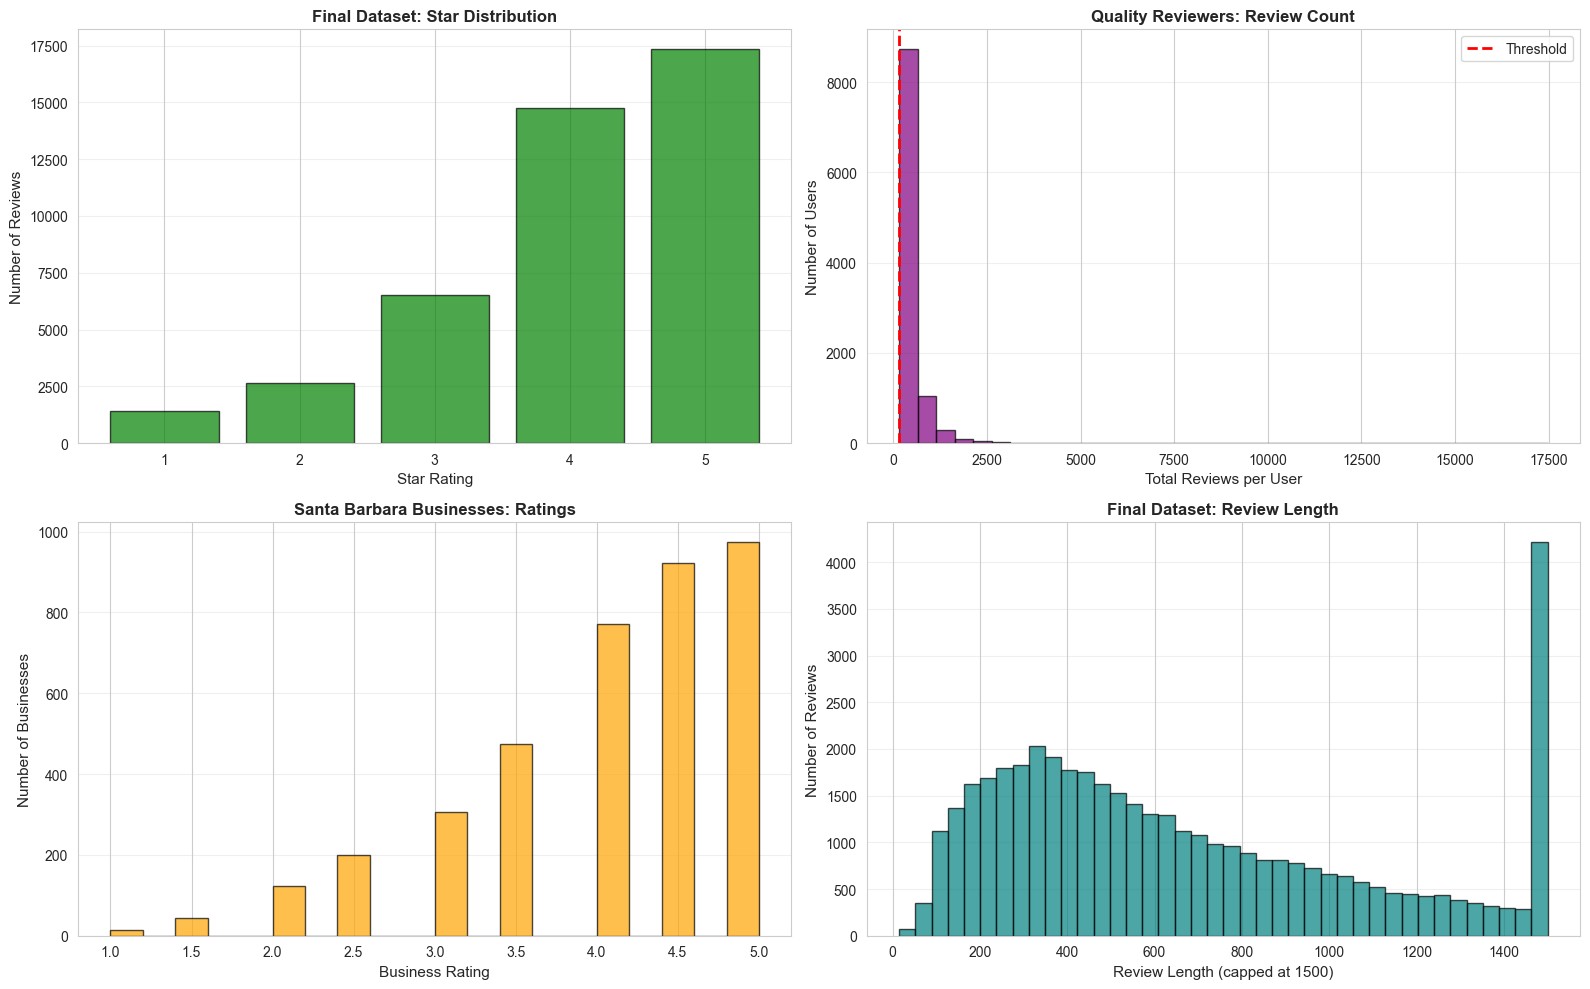

In [25]:
# Visualize final dataset
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Star distribution
final_stars = final_reviews["stars"].value_counts().sort("stars")
axes[0, 0].bar(
    final_stars["stars"].to_list(),
    final_stars["count"].to_list(),
    color="green",
    edgecolor="black",
    alpha=0.7,
    width=0.8,
)
axes[0, 0].set_xlabel("Star Rating", fontsize=11)
axes[0, 0].set_ylabel("Number of Reviews", fontsize=11)
axes[0, 0].set_title("Final Dataset: Star Distribution", fontsize=12, fontweight="bold")
axes[0, 0].grid(True, alpha=0.3, axis="y")

# Quality reviewer distribution
axes[0, 1].hist(
    sb_quality_users["review_count"].to_list(),
    bins=35,
    color="purple",
    edgecolor="black",
    alpha=0.7,
)
axes[0, 1].axvline(150, color="red", linestyle="--", linewidth=2, label="Threshold")
axes[0, 1].set_xlabel("Total Reviews per User", fontsize=11)
axes[0, 1].set_ylabel("Number of Users", fontsize=11)
axes[0, 1].set_title("Quality Reviewers: Review Count", fontsize=12, fontweight="bold")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis="y")

# Business ratings
axes[1, 0].hist(
    sb_businesses["stars"].to_list(),
    bins=20,
    color="orange",
    edgecolor="black",
    alpha=0.7,
)
axes[1, 0].set_xlabel("Business Rating", fontsize=11)
axes[1, 0].set_ylabel("Number of Businesses", fontsize=11)
axes[1, 0].set_title(
    "Santa Barbara Businesses: Ratings", fontsize=12, fontweight="bold"
)
axes[1, 0].grid(True, alpha=0.3, axis="y")

# Review text length
final_lengths_capped = [min(x, 1500) for x in final_reviews["text_length"].to_list()]
axes[1, 1].hist(
    final_lengths_capped, bins=40, color="teal", edgecolor="black", alpha=0.7
)
axes[1, 1].set_xlabel("Review Length (capped at 1500)", fontsize=11)
axes[1, 1].set_ylabel("Number of Reviews", fontsize=11)
axes[1, 1].set_title("Final Dataset: Review Length", fontsize=12, fontweight="bold")
axes[1, 1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

## Part 6: Export Filtered Data

Save the processed data for the next stage of the pipeline.

In [26]:
# Create output directory
output_dir = Path("../data/processed")
output_dir.mkdir(exist_ok=True, parents=True)

print("=== EXPORTING FILTERED DATASETS ===\n")

# Export as Parquet (efficient columnar format)
print("Saving files...")

sb_businesses.write_parquet(output_dir / "businesses_sb.parquet")
print(f" businesses_sb.parquet: {len(sb_businesses):,} records")

sb_quality_users.write_parquet(output_dir / "users_quality.parquet")
print(f" users_quality.parquet: {len(sb_quality_users):,} records")

final_reviews.write_parquet(output_dir / "reviews_filtered.parquet")
print(f" reviews_filtered.parquet: {len(final_reviews):,} records")

print(f"\n Files saved to: {output_dir.absolute()}")

# Estimate file sizes
print(f"\n Approximate sizes:")
for file in output_dir.glob("*.parquet"):
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"  {file.name}: {size_mb:.1f} MB")

=== EXPORTING FILTERED DATASETS ===

Saving files...
 businesses_sb.parquet: 3,829 records
 users_quality.parquet: 10,263 records
 reviews_filtered.parquet: 42,687 records

 Files saved to: /Users/anvitasuresh/Desktop/de_proj/../data/processed

 Approximate sizes:
  reviews_filtered.parquet: 12.8 MB
  users_quality.parquet: 61.5 MB
  businesses_sb.parquet: 0.4 MB
